# Desafío Avanzado

In [1]:
# 1. ¿Cómo limpiarías y transformarías las variables `budget`, `revenue` y `popularity` para evitar errores 
# en el modelo de regresión que predice el `rating`, considerando posibles ceros, nulos o valores extremos?

# 2. ¿Qué pasos seguirías para crear una variable que indique los años transcurridos desde `date_added` hasta hoy, 
# y cómo podrías usarla para estudiar tendencias en el `rating`?

# 3. ¿Cómo construirías una tabla que resuma la popularidad media, el presupuesto medio y el rating medio 
# por país (`country`), y qué visualización usarías para detectar anomalías o diferencias regionales?

# 4. ¿Cómo aplicarías técnicas básicas de análisis de texto para descubrir qué palabras aparecen más frecuentemente 
# en las descripciones de los títulos con rating alto?

# 5. ¿Qué actores o actrices aparecen con más frecuencia en títulos etiquetados como `Drama` o `Documentary`, 
# y cómo representarías esa información para facilitar su interpretación?

# 6. ¿Qué método automatizado usarías para seleccionar las variables más influyentes (por ejemplo `budget`, `release_year`, 
# `popularity`, `revenue`, etc.) en un modelo que predice `rating`?

# 7. ¿Cómo construirías un pipeline que incluya imputación de valores nulos en `budget` y `revenue`, 
# transformación del año de estreno (`release_year`) en décadas, codificación del país (`country`) 
# y vectorización del género (`listed_in`), para entrenar un modelo que prediga `rating`?

# 8. ¿Cómo entrenarías y validarías una red neuronal sencilla (`MLPRegressor`) para predecir el `rating`, 
# y qué métricas de evaluación utilizarías para comprobar su rendimiento?

# 9. ¿Cómo interpretarías las predicciones de un modelo basado en árboles (por ejemplo, RandomForestRegressor) 
# que estima el `rating`, analizando qué variables tienen mayor importancia?

# 10. ¿Cómo automatizarías la generación semanal de un informe que resuma: 
# títulos añadidos recientemente (`date_added`), número de estrenos por país y evolución del rating medio por mes?


In [2]:
# 1 ------------------------------------------------------------
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

df = pd.read_csv("titles.csv")

df["budget"] = pd.to_numeric(df["budget"], errors="coerce")
df["revenue"] = pd.to_numeric(df["revenue"], errors="coerce")
df["popularity"] = pd.to_numeric(df["popularity"], errors="coerce")
df["rating"] = pd.to_numeric(df["rating"], errors="coerce")
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,genres,language,description,popularity,vote_count,vote_average,budget,revenue
0,10192,Movie,Shrek Forever After,Mike Mitchell,"Mike Myers, Eddie Murphy, Cameron Diaz, Antoni...",United States of America,2010-05-16,2010,6.380,NaN,"Comedy, Adventure, Fantasy, Animation, Family",en,A bored and domesticated Shrek pacts with deal...,203.893,7449,6.380,165000000,752600867
1,27205,Movie,Inception,Christopher Nolan,"Leonardo DiCaprio, Joseph Gordon-Levitt, Ken W...","United Kingdom, United States of America",2010-07-15,2010,8.369,NaN,"Action, Science Fiction, Adventure",en,"Cobb, a skilled thief who commits corporate es...",156.242,37119,8.369,160000000,839030630
2,12444,Movie,Harry Potter and the Deathly Hallows: Part 1,David Yates,"Daniel Radcliffe, Emma Watson, Rupert Grint, T...","United Kingdom, United States of America",2010-11-17,2010,7.744,NaN,"Adventure, Fantasy",en,"Harry, Ron and Hermione walk away from their l...",121.191,19327,7.744,250000000,954305868
3,38757,Movie,Tangled,"Byron Howard, Nathan Greno","Mandy Moore, Zachary Levi, Donna Murphy, Ron P...",United States of America,2010-11-24,2010,7.600,NaN,"Animation, Family, Adventure",en,"Feisty teenager Rapunzel, who has long and mag...",111.762,11638,7.600,260000000,592461732
4,10191,Movie,How to Train Your Dragon,"Chris Sanders, Dean DeBlois","Jay Baruchel, Gerard Butler, Craig Ferguson, A...",United States of America,2010-03-18,2010,7.800,NaN,"Fantasy, Adventure, Animation, Family",en,As the son of a Viking leader on the cusp of m...,110.044,13259,7.800,165000000,494879471


In [3]:
# 2 ------------------------------------------------------------
df["date_added"] = pd.to_datetime(df["date_added"], errors="coerce")
df["years_since_added"] = datetime.now().year - df["date_added"].dt.year

In [4]:
# 3 ------------------------------------------------------------
df["country_clean"] = df["country"].astype(str).str.split(",").str[0].str.strip()

tabla_pais = df.groupby("country_clean")[["popularity", "budget", "rating"]].mean().dropna().sort_values("budget", ascending = False).round(2)
tabla_pais

,popularity,budget,rating
country_clean,,,
United Arab Emirates,20.24,29157894.74,6.27
Bulgaria,39.80,27734405.41,5.98
New Zealand,20.21,24953658.54,6.19
Panama,15.16,20000000.00,6.60
China,22.65,18757464.63,6.19
...,...,...,...
Saudi Arabia,10.46,0.00,6.25
St. Kitts and Nevis,318.84,0.00,5.95
Sri Lanka,9.56,0.00,5.98


In [5]:
# 4 ------------------------------------------------------------
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk

# nltk.download("punkt")
# nltk.download("stopwords")

stop_words = set(stopwords.words("english"))

descripciones = df[df["rating"] > 7]["description"].dropna().str.lower()
tokens = descripciones.apply(word_tokenize)
tokens_filtrados = [palabra for lista in tokens for palabra in lista if palabra.isalpha() and palabra not in stop_words]

top_palabras = pd.Series(tokens_filtrados).value_counts().head(10)
top_palabras

life      634
world     482
one       478
new       458
young     429
family    380
story     372
love      328
two       314
man       284
Name: count, dtype: int64

In [6]:
# 5 ------------------------------------------------------------
df_gen = df.dropna(subset=["genres", "cast"]).copy()

df_gen["genre_list"] = df_gen["genres"].str.split(", ")
df_gen["actor_list"] = df_gen["cast"].str.split(", ")

df_explode = df_gen.explode("genre_list").explode("actor_list")

df_explode["genre_list"] = df_explode["genre_list"].str.strip()
df_explode["actor_list"] = df_explode["actor_list"].str.strip()

frecuencia = df_explode.groupby(["genre_list", "actor_list"]).size().reset_index(name="conteo")

top_actores_por_genero = frecuencia.sort_values(["genre_list", "conteo"], ascending=[True, False]).groupby("genre_list").head(10)

top_actores_por_genero

,genre_list,actor_list,conteo
1130,Action,Bruce Willis,47
7285,Action,Scott Adkins,35
2036,Action,Dolph Lundgren,26
6053,Action,Nicolas Cage,26
1797,Action,Danny Trejo,25
...,...,...,...
115780,Western,Bruce Dern,3
115836,Western,Danny Trejo,3
116022,Western,Kevin Costner,3
116030,Western,Kodi Smit-McPhee,3


In [11]:
# 6 ------------------------------------------------------------
X = df[["budget", "revenue", "popularity", "release_year", "years_since_added"]]
y = df["rating"]
X = X[X.notnull().all(axis=1)]
y = y.loc[X.index]

modelo = RandomForestRegressor(n_estimators=100, random_state=0)
modelo.fit(X, y)

RandomForestRegressor(random_state=0)

In [12]:
# 7 ------------------------------------------------------------
df["decade"] = (df["release_year"] // 10) * 10

df_model = df[["budget", "revenue", "popularity", "country", "decade", "rating"]].dropna()
df_model = df_model[df_model["country"].isin(df_model["country"].value_counts().head(10).index)]

preprocesado = ColumnTransformer([
    ("num", StandardScaler(), ["budget", "revenue", "popularity"]),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), ["country", "decade"])
])

pipeline = Pipeline([
    ("preproc", preprocesado),
    ("modelo", LinearRegression())
])

X_pipe = df_model.drop("rating", axis=1)
y_pipe = df_model["rating"]
pipeline.fit(X_pipe, y_pipe)

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['budget', 'revenue',
                                                   'popularity']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['country', 'decade'])])),
                ('modelo', LinearRegression())])

In [9]:
# 8 ------------------------------------------------------------
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor

df["decade"] = (df["release_year"] // 10) * 10

df_model = df[[
    "budget", "revenue", "popularity", "release_year", "years_since_added",
    "country", "decade", "rating"
]].dropna()

df_model = df_model[df_model["country"].isin(df_model["country"].value_counts().head(10).index)]

X = df_model.drop("rating", axis=1)
y = df_model["rating"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

preprocesado = ColumnTransformer([
    ("num", StandardScaler(), ["budget", "revenue", "popularity", "release_year", "years_since_added"]),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), ["country", "decade"])
])

# MLP pipeline
pipeline_mlp = Pipeline([
    ("preproc", preprocesado),
    ("mlp", MLPRegressor(hidden_layer_sizes=(100, 100), alpha=0.001, max_iter=500, early_stopping=True, random_state=42))
])

# XGBoost pipeline
pipeline_xgb = Pipeline([
    ("preproc", preprocesado),
    ("xgb", XGBRegressor(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    ))
])

# Cross-validation
scores_mlp = cross_val_score(pipeline_mlp, X, y, cv=3, scoring="r2")
scores_xgb = cross_val_score(pipeline_xgb, X, y, cv=3, scoring="r2")

print("MLP - R2 medio:", round(scores_mlp.mean(), 3))
print("MLP - R2 por fold:", scores_mlp)

print("XGBoost - R2 medio:", round(scores_xgb.mean(), 3))
print("XGBoost - R2 por fold:", scores_xgb)


MLP - R2 medio: -0.17
MLP - R2 por fold: [ 0.02530247  0.01627948 -0.55095689]
XGBoost - R2 medio: -0.052
XGBoost - R2 por fold: [-0.05482306  0.01902528 -0.12051375]


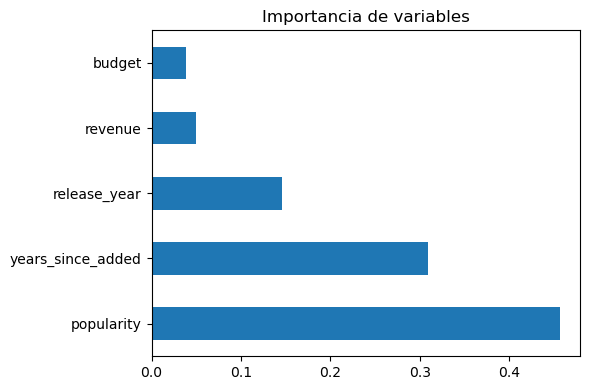

In [13]:
# 9 ------------------------------------------------------------
importancias = pd.Series(modelo.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(6,4))
importancias.plot(kind="barh", title="Importancia de variables")
plt.tight_layout()


In [17]:
# 10 -----------------------------------------------------------
informe = df[df["date_added"] >= "2023-01-01"]
resumen = informe.groupby("country")[["title"]].count().sort_values(by = "title",ascending=False)
mensual = df.dropna(subset=["date_added"])
mensual["month"] = mensual["date_added"].dt.to_period("M")
evolucion = mensual.groupby("month")[["rating"]].mean()
evolucion.to_html()

'<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th></th>\n      <th>rating</th>\n    </tr>\n    <tr>\n      <th>month</th>\n      <th></th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr>\n      <th>2010-01</th>\n      <td>5.879487</td>\n    </tr>\n    <tr>\n      <th>2010-02</th>\n      <td>6.156280</td>\n    </tr>\n    <tr>\n      <th>2010-03</th>\n      <td>6.188583</td>\n    </tr>\n    <tr>\n      <th>2010-04</th>\n      <td>6.002657</td>\n    </tr>\n    <tr>\n      <th>2010-05</th>\n      <td>6.111217</td>\n    </tr>\n    <tr>\n      <th>2010-06</th>\n      <td>6.156089</td>\n    </tr>\n    <tr>\n      <th>2010-07</th>\n      <td>6.047758</td>\n    </tr>\n    <tr>\n      <th>2010-08</th>\n      <td>6.074676</td>\n    </tr>\n    <tr>\n      <th>2010-09</th>\n      <td>6.189404</td>\n    </tr>\n    <tr>\n      <th>2010-10</th>\n      <td>6.082650</td>\n    </tr>\n    <tr>\n      <th>2010-11</th>\n      <td>6.280364</td>\n    </tr>\n    <tr>\

In [15]:
resumen

,title
country,
United States of America,854
India,119
United Kingdom,117
Japan,114
France,112
...,...
"Austria, India, Russia, Turkey",1
"Austria, United States of America",1
"Cambodia, France, Qatar, Taiwan, Turkey",1


In [ ]:
resumen.to_csv("estrenos_por_pais.csv")
evolucion.to_csv("rating_mensual.csv")